# Model Training

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')
from utils.machine_learning import preprocess_pipeline, evaluate_models, visualize_roc_curves, visualize_confusion_matrix, initiate_model_trainer, plot_precision_recall_threshold, plot_feature_importance

# Data

In [2]:
df_original = pd.read_csv("./Ml_Datasets/original.csv")
df_all = pd.read_csv("./Ml_Datasets/all_features.csv")

# Preprocessing the Data

### For the preprocess step, the data will be divided into a train and test split. Also, onehot encoding will be performed on the categorical columns of the datasets, and the numerical columns will be scaled using the robust scaler, since the outliers of the columns `rotational_speed` and `torque` were not removed from the original dataset

In [65]:
X_train_original, X_test_original, y_train_original, y_test_original = preprocess_pipeline(df_original, test_size=0.3, target_name="target")
X_train_all, X_test_all, y_train_all, y_test_all = preprocess_pipeline(df_all, test_size=0.3, target_name="target")

# Modeling

### For the modeling phase, three models will be used: Logistic Regression, Random Forest and KNN. Each model will be trained and tested using the original dataset and the new dataset that contains the new engineered features. 
### During each training and testing, two methods will be used to solve the imbalance issue of the target. The first one is using the parameter `class_weight` on the models that have it. The second method is the utilization of `SMOTE`, an oversampling method that uses synthetic data to balance the target. `SMOTE` will only be applied to the training sets, with the tests sets having the original imbalance of the data

# Models on Original Features

## Using class_weight = balanced

In [4]:
model_report_original = initiate_model_trainer((X_train_original, y_train_original, X_test_original, y_test_original), "Original_Features", use_smote=False)

Successfully registered model 'Logistic Regression - Original_Features'.
2024/02/05 13:37:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - Original_Features, version 1
Created version '1' of model 'Logistic Regression - Original_Features'.
Successfully registered model 'Random Forest - Original_Features'.
2024/02/05 13:39:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - Original_Features, version 1
Created version '1' of model 'Random Forest - Original_Features'.
Successfully registered model 'KNN - Original_Features'.
2024/02/05 13:39:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNN - Original_Features, version 1
Created version '1' of model 'KNN - Original_Features'.


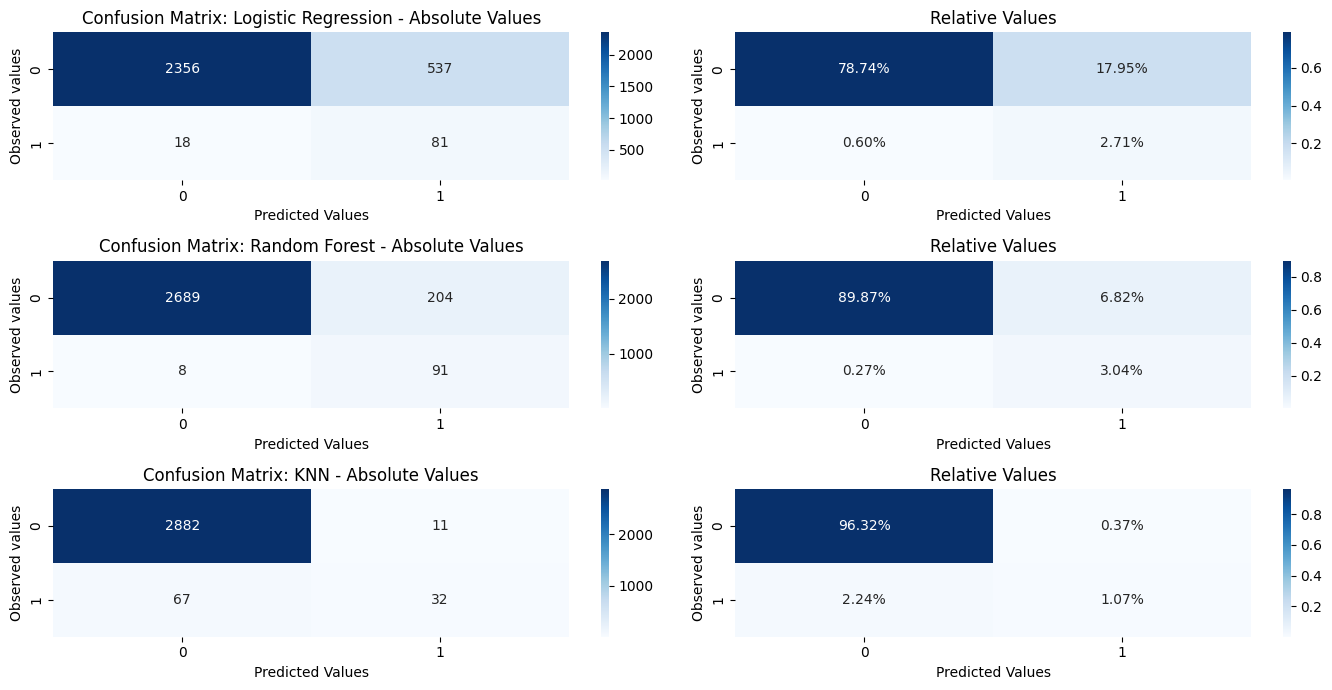

In [5]:
visualize_confusion_matrix(y_test_original, model_report_original, 3, 2)

### Observations:
- The logistic regression model had an extremely high number of false positives, indicating that the model has very little `precision`. Despite having a high `recall`, the amount of false positives makes this model far from ideal in an industry environment
- The random forest model only failed to report eight machines as machines susceptible to failures, but similarly to the logistic regression model, it has a lot of false positives.
- The KNN model was the overall best performer when looking exclusively at metrics. But compared to the other two, it failed to detect the majority of the machines that would actually need maintenance, with a lot of false negatives and an extremely low `recall`

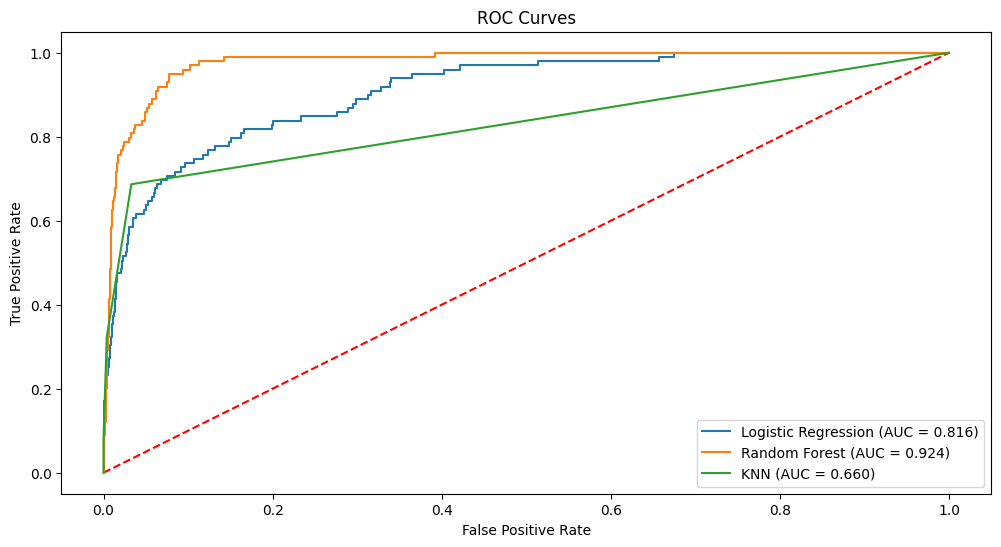

In [6]:
visualize_roc_curves(model_report_original)

### Observations:
- The random forest model is the clear winner when plotting the `ROC` curves, with a score of 0.92. This indicates that the random forest model is excellent at discriminating the data between both classes, covering a large area under the curve
- The logistic regression model demonstrated that it's somewhat capable of discriminating the data, but it's not close to the random forest model
- Looking only at the metrics, the KNN model seemed like it was the best model, performance wise. But looking at it's `ROC` curve, it's clear that the model is extremely bad at discriminating the data between both classes, with a score of only 0.66

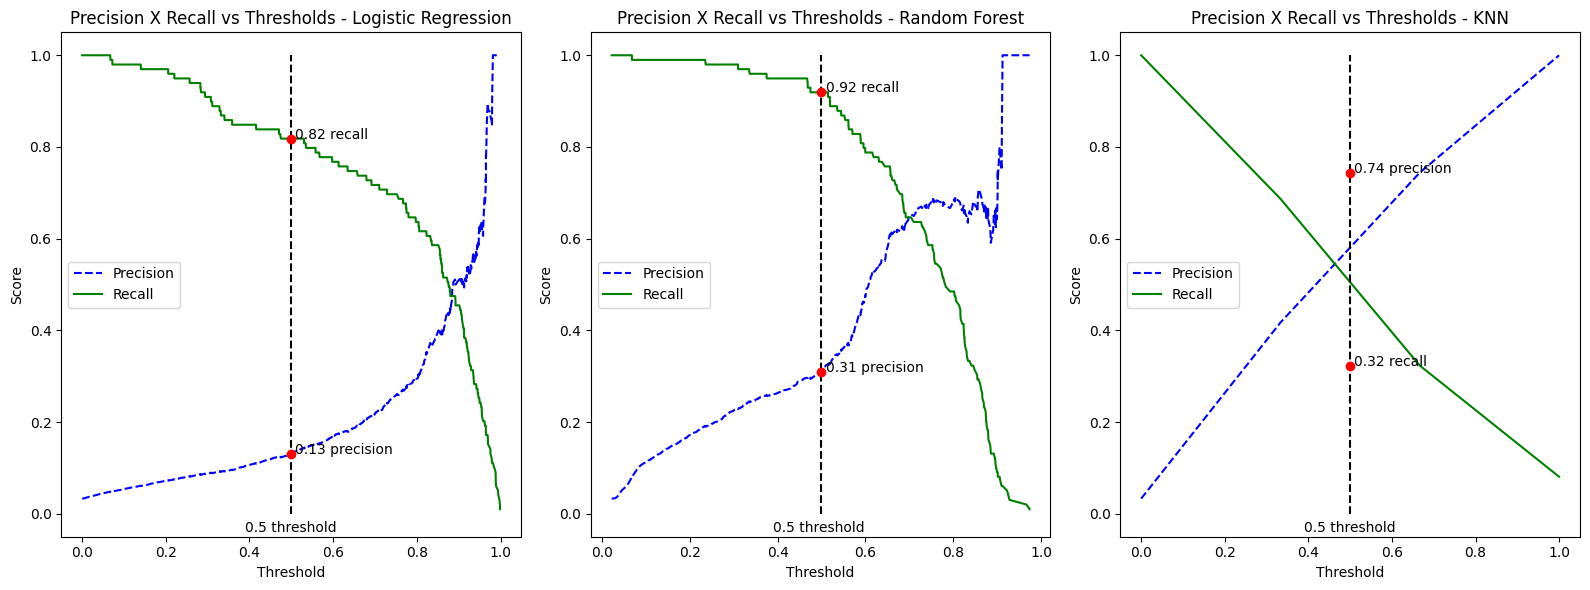

In [7]:
plot_precision_recall_threshold(y_test_original, X_test_original, model_report_original, 1, 3)

### Observations:
- As is the case in every model, trying to perfect balance the `recall` and `precision` would result in a very big reduction of the `recall` metric. This means that the models would have a lot more false negatives, missing a lot more machines that would require maintenance

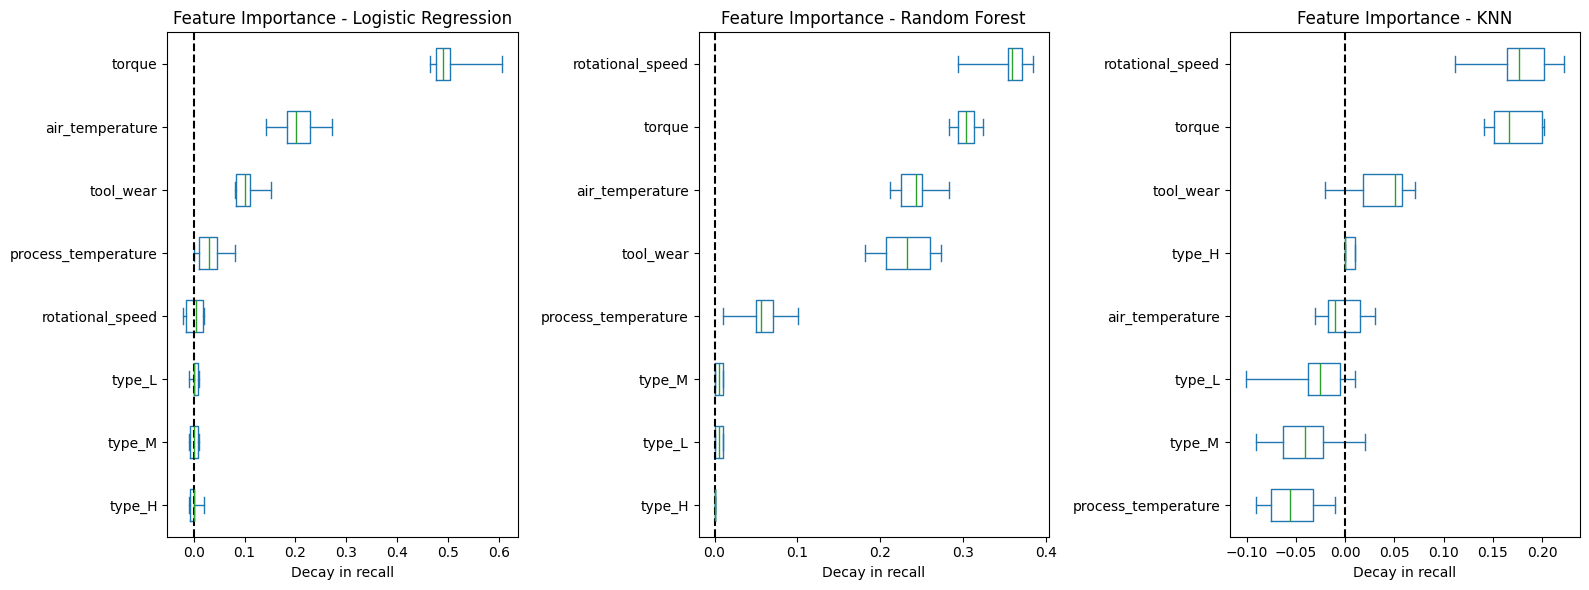

In [8]:
plot_feature_importance(y_test_original, X_test_original, model_report_original, "recall", 1, 3)

### Observations:
- The logistic regression model is heavily dependent on the `torque` feature, ranging from 0.45 to 0.6 decay in recall. This means that the model relies on the correct values of this feature to make predictions. `Air_temperature` is the second most important feature, ranging only from 0.15 to 0.3, with `tool_wear` close behind. All other features are basically non-significant to the model
- On the random forest model, we have four features that the model considers to be important, with their importance being more balanced in relation to the logistic regression model. In this case, `rotational_speed` is the most important feature, closely followed by `torque`, with `air_temperature` and `tool_wear` almost tied for third and fourth place. The `type of product` is ignored by the model, and `process_temperature` ranges between 0.01 to 0.1
- On the KNN model, wee see that half of the features are actually hurting the model predictions, with the model taking the values of these features as noise or incorrect data. `Torque` and `rotational_speed` are the only features that have any real positive impact on the model

## Using SMOTE

In [9]:
model_report_original_smote = initiate_model_trainer((X_train_original, y_train_original, X_test_original, y_test_original), "Original_Features", use_smote=True)

Registered model 'Logistic Regression - Original_Features' already exists. Creating a new version of this model...
2024/02/05 13:59:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - Original_Features, version 2
Created version '2' of model 'Logistic Regression - Original_Features'.
Registered model 'Random Forest - Original_Features' already exists. Creating a new version of this model...
2024/02/05 14:04:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - Original_Features, version 2
Created version '2' of model 'Random Forest - Original_Features'.
Registered model 'KNN - Original_Features' already exists. Creating a new version of this model...
2024/02/05 14:05:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNN - Or

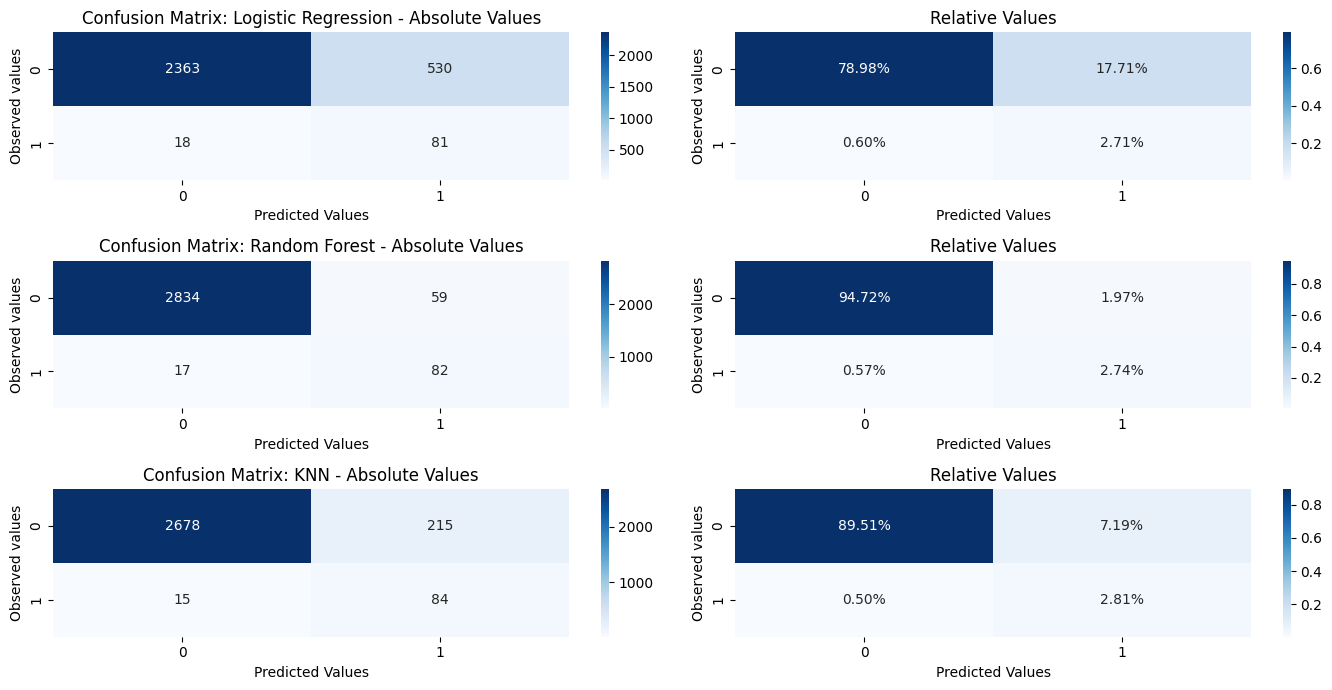

In [10]:
visualize_confusion_matrix(y_test_original, model_report_original_smote, 3, 2)

### Observations:
- When using `SMOTE` to balance the data, the logistic regression model had no changes regarding its confusion matrix
- For the random forest model, the `SMOTE` utilization improved the model in terms of false positives, with a total of 59, compared to more than 200 in the previous version. Another positive point is that despite increasing the `precision`, the `recall` went up just by a bit, with the number of false negatives now at 17, versus 8 from the previous version
- On the KNN model, its performance is very similar to the previous version of the random forest, with the KNN now being able to have low false negatives but with a high number of false positives

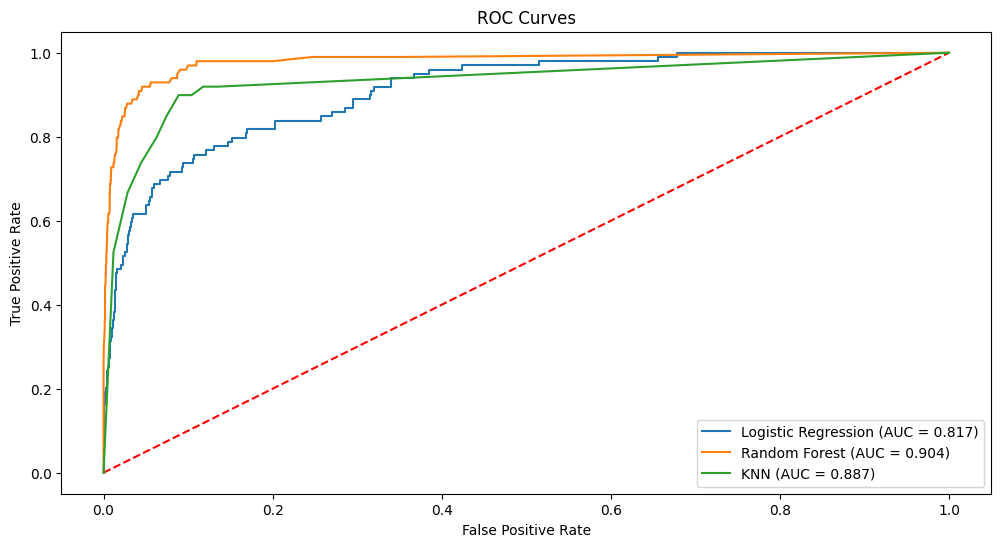

In [25]:
visualize_roc_curves(model_report_original_smote)

### Observations:
- Again, we can see that the logistic regression model did not benefit from the use of `SMOTE`, with its `ROC` curve being the same as the previous version
- The random forest model improved when looking at the confusion matrix, but its `ROC` curve suffered a small decrease, now at 0.90
- The KNN model was the biggest winner regarding its `ROC` curve in relation to the previous version, now with a value of 0.88, indicating that this model can very well discriminate the data between both classes

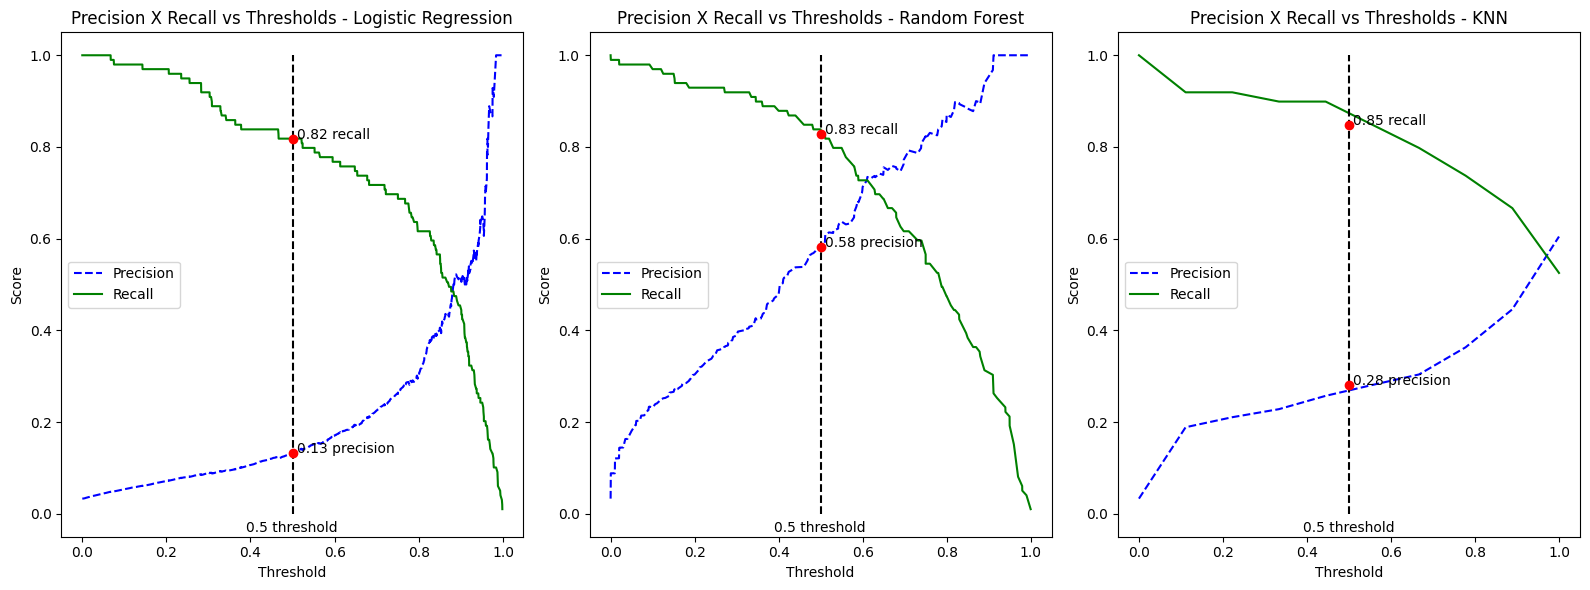

In [12]:
plot_precision_recall_threshold(y_test_original, X_test_original, model_report_original_smote, 1, 3)

### Observations:
- No changes to the logistic regression model
- The random forest has a higher `precision` score now, but it's sill not attractive to change its threshold to increase the `recall` or to balance the metrics
- The KNN model is showing a very similar behavior to the logistic regression model, with the possibility to decrease its threshold to achieve a higher `recall`, without losing much `precision`

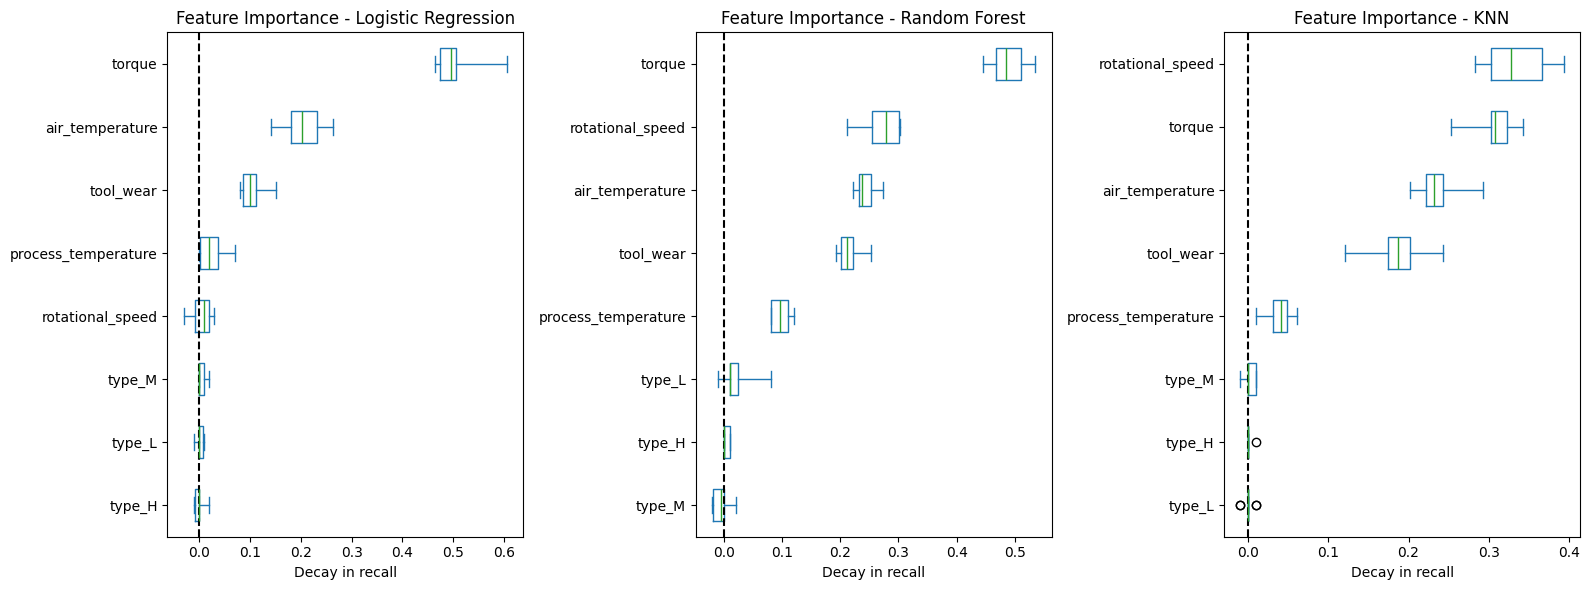

In [13]:
plot_feature_importance(y_test_original, X_test_original, model_report_original_smote, "recall", 1, 3)

### Observations:
- The logistic regression model shows the same behavior regarding feature importance
- The random forest model shows that the `torque` feature is the most important, with `rotational_speed`, `air_temperature` and `tool_wear` tied for second, third and fourth place. `Process_temperature` had a slight improvement in its importance, and the `type of product` is still irrelevant
- The KNN model had a drastic change. Now, half the features are important to the model, and no feature is hurting its predictions. Also, it shows a similar behavior as the random forest, with the same four features as the most important ones, and the `type of product` being irrelevant

# Models on All Features

## Using class_weight = balanced

In [14]:
model_report_all = initiate_model_trainer((X_train_all, y_train_all, X_test_all, y_test_all), "All_Features", use_smote=False)

Successfully registered model 'Logistic Regression - All_Features'.
2024/02/05 14:21:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - All_Features, version 1
Created version '1' of model 'Logistic Regression - All_Features'.
Successfully registered model 'Random Forest - All_Features'.
2024/02/05 14:24:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - All_Features, version 1
Created version '1' of model 'Random Forest - All_Features'.
Successfully registered model 'KNN - All_Features'.
2024/02/05 14:24:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNN - All_Features, version 1
Created version '1' of model 'KNN - All_Features'.


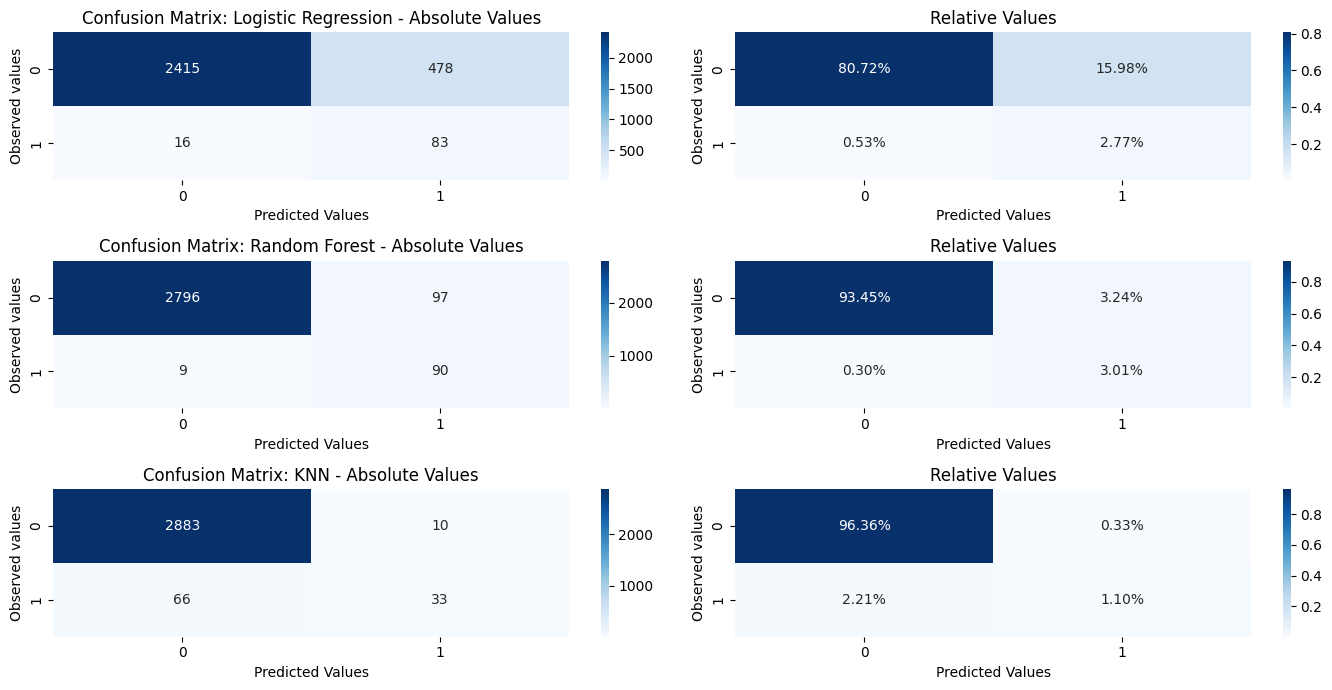

In [15]:
visualize_confusion_matrix(y_test_all, model_report_all, 3, 2)

### Observations:
- The logistic regression model still shows a similar behavior in relation to the versions of the other dataset, but with the new features, the number of false positives was reduced
- The number of false positives in the random forest decreased to 97 without the use of `SMOTE`, with the false negatives maintaining the same level
- KNN model showed the same behavior as in the original dataset

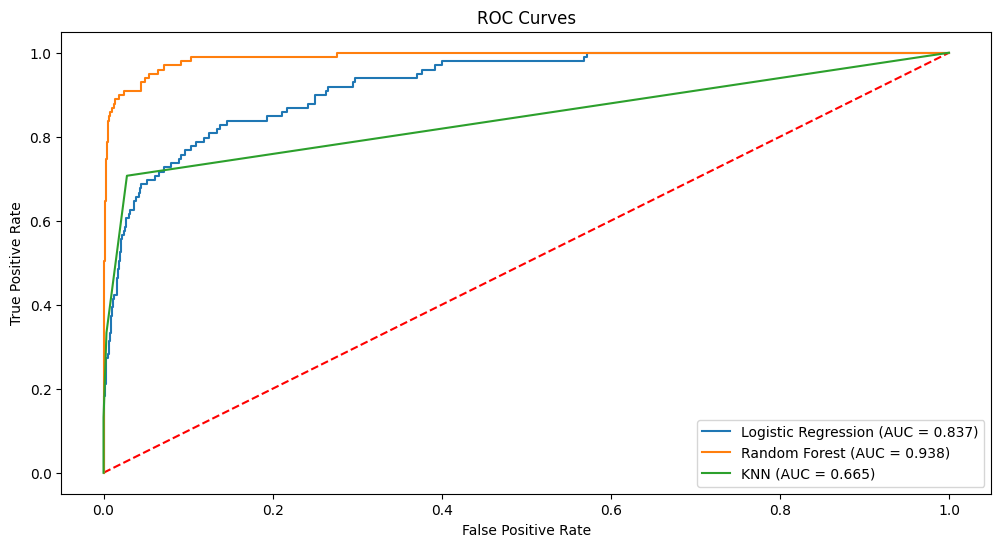

In [26]:
visualize_roc_curves(model_report_all)

### Observations:
- Slight increase in the score of the logistic regression model, now at 0.83
- The random forest model continues to be the best one here, with a score of almost 0.94
- No changes to the KNN model

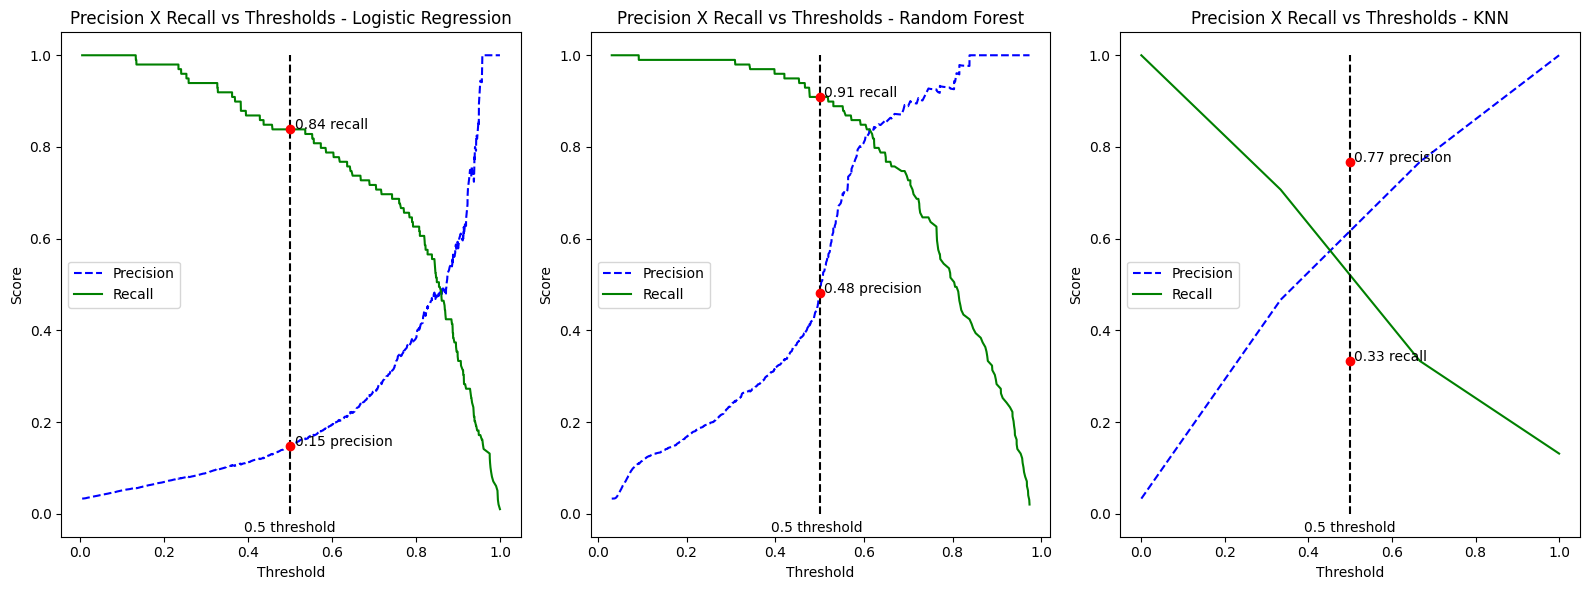

In [18]:
plot_precision_recall_threshold(y_test_all, X_test_all, model_report_all, 1, 3)

### Observations:
- Logistic regression and KNN models showing the same behavior
- Changing the threshold of the random forest model is now a very good idea. With a threshold of 0.6, theres minimal loss of `recall`, and the `precision` jumps from 0.48 to 0.8 

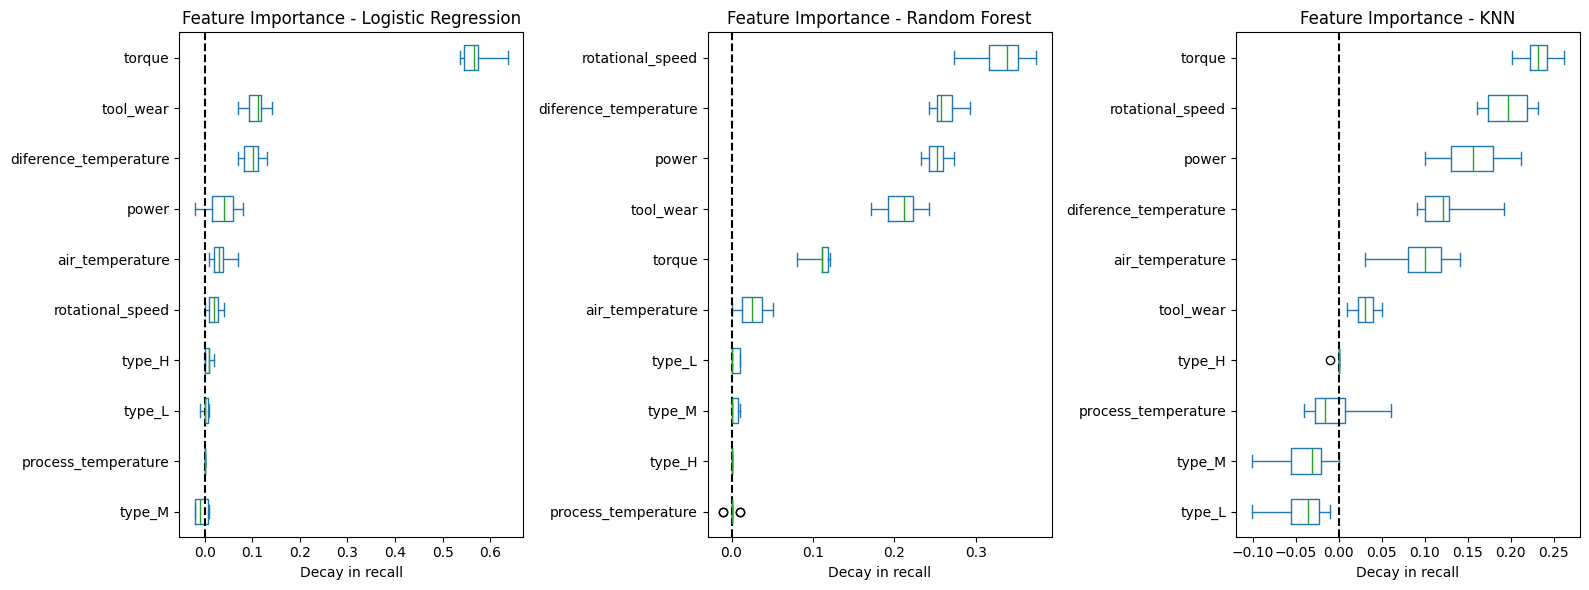

In [19]:
plot_feature_importance(y_test_all, X_test_all, model_report_all, "recall", 1, 3)

### Observations:
- Logistic regression and KNN models show the same behavior, but the new features appear in third place on both models as the most important ones
- On the random forest, the new features are tied for second and third place, with only `rotational_speed` being considered more important

## Using SMOTE

In [20]:
model_report_all_smote = initiate_model_trainer((X_train_all, y_train_all, X_test_all, y_test_all), "All_Features", use_smote=True)

Registered model 'Logistic Regression - All_Features' already exists. Creating a new version of this model...
2024/02/05 14:30:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - All_Features, version 2
Created version '2' of model 'Logistic Regression - All_Features'.
Registered model 'Random Forest - All_Features' already exists. Creating a new version of this model...
2024/02/05 14:37:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - All_Features, version 2
Created version '2' of model 'Random Forest - All_Features'.
Registered model 'KNN - All_Features' already exists. Creating a new version of this model...
2024/02/05 14:38:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNN - All_Features, version 2
Created versi

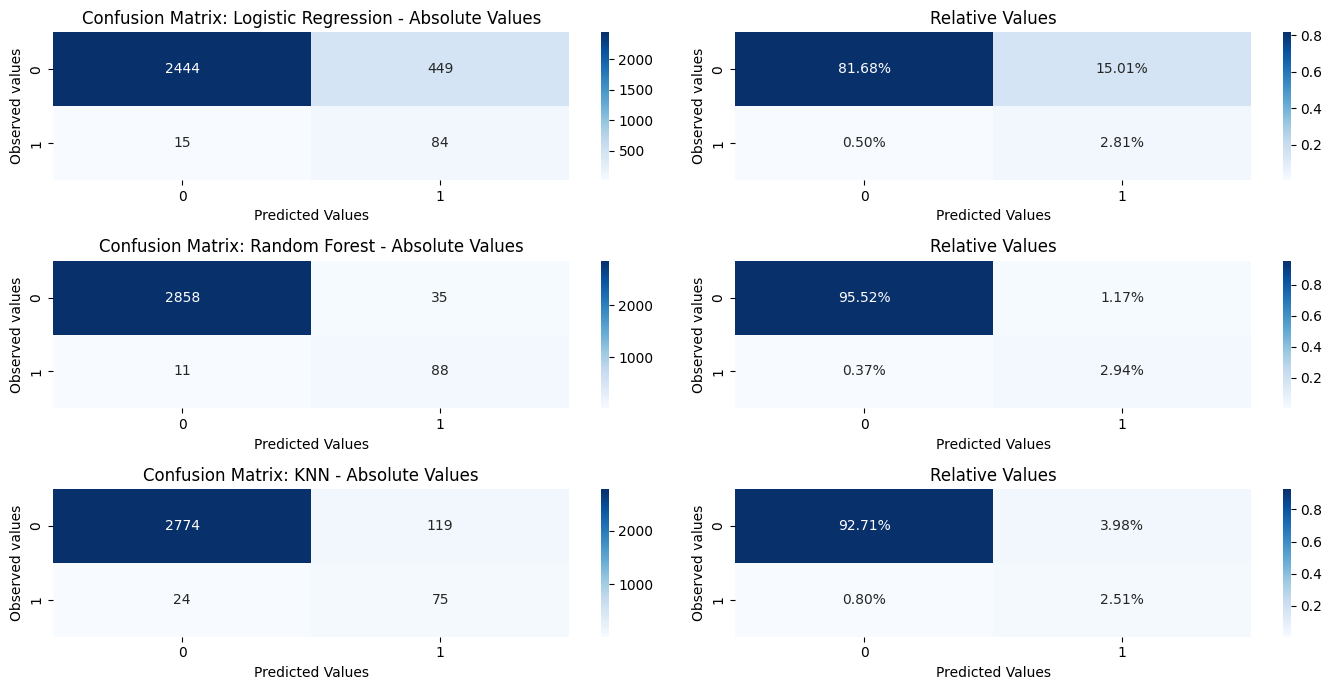

In [72]:
visualize_confusion_matrix(y_test_all, model_report_all_smote, 3, 2)

### Observations:
- Logistic regression still displays the same behavior
- Random forest had its best results, looking only at the confusion matrix. Only 11 false negatives and the lowest number of false positives of any model, at 35
- KNN had its best results, with 24 false negatives, and its lowest number of false positives, at 119

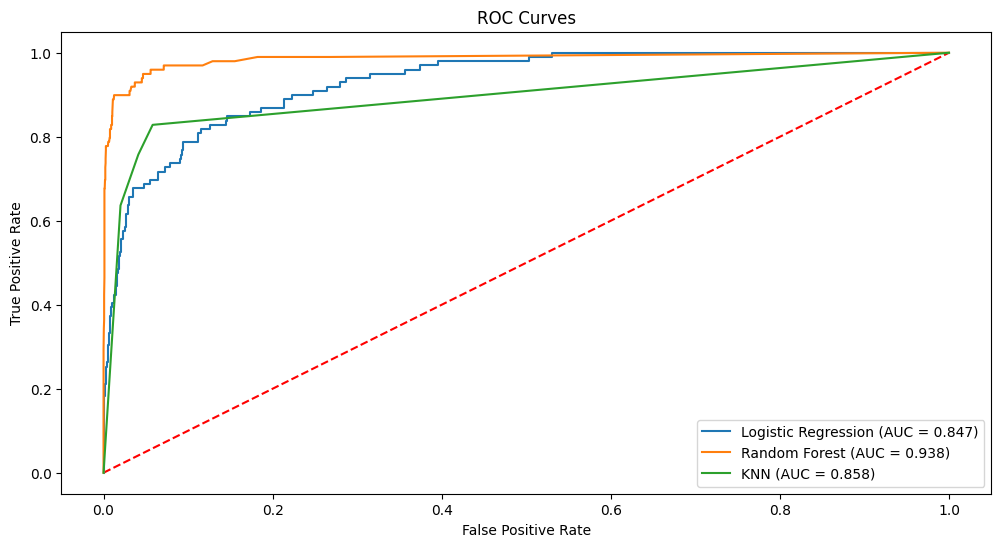

In [54]:
visualize_roc_curves(model_report_all_smote)

### Observations:
- Only the KNN had a significant benefit here, with its score jumping from 0.66 to almost 0.86

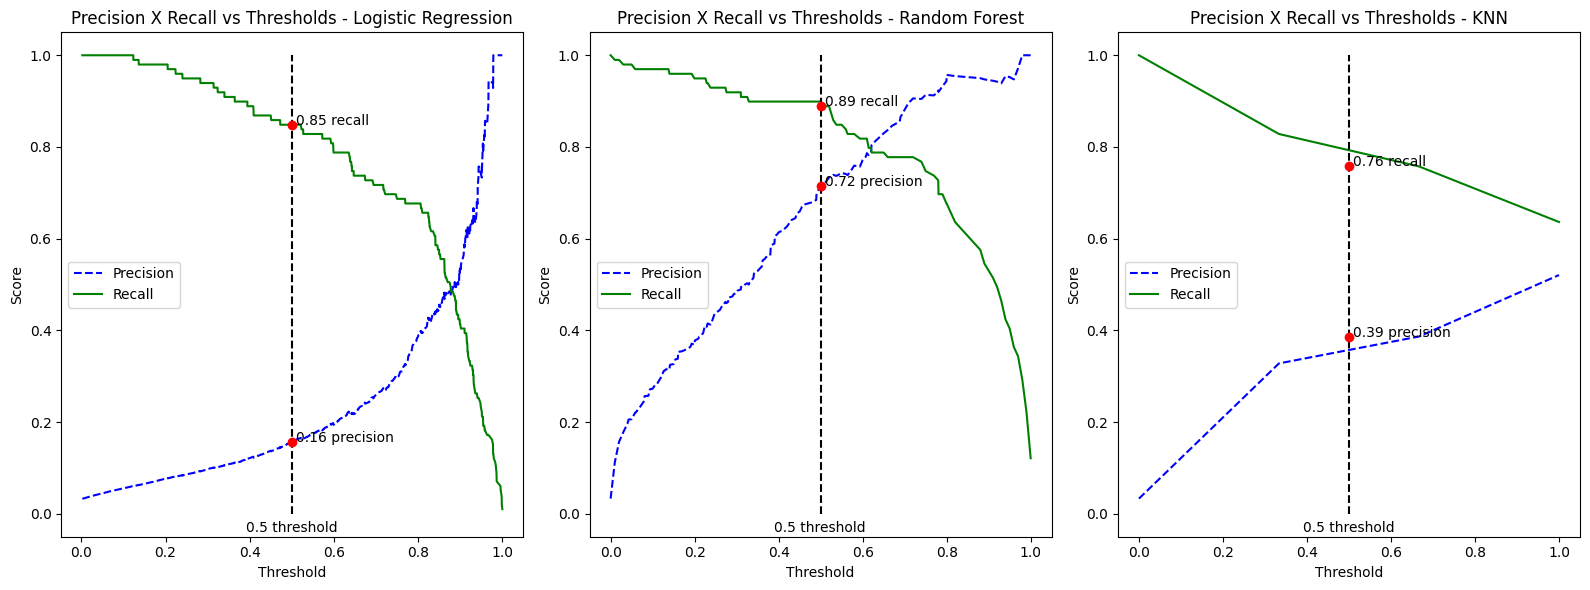

In [73]:
plot_precision_recall_threshold(y_test_all, X_test_all, model_report_all_smote, 1, 3)

### Observations:
- While the logistic regression and KNN showed similar behavior when `SMOTE` was used on the original dataset, the random forest model showed very strong metrics. Compared to the balanced `class_weight` on the previous run, the loss in recall would be too high when changing the threshold to balance the metrics, and there's no real gain to moving the threshold back

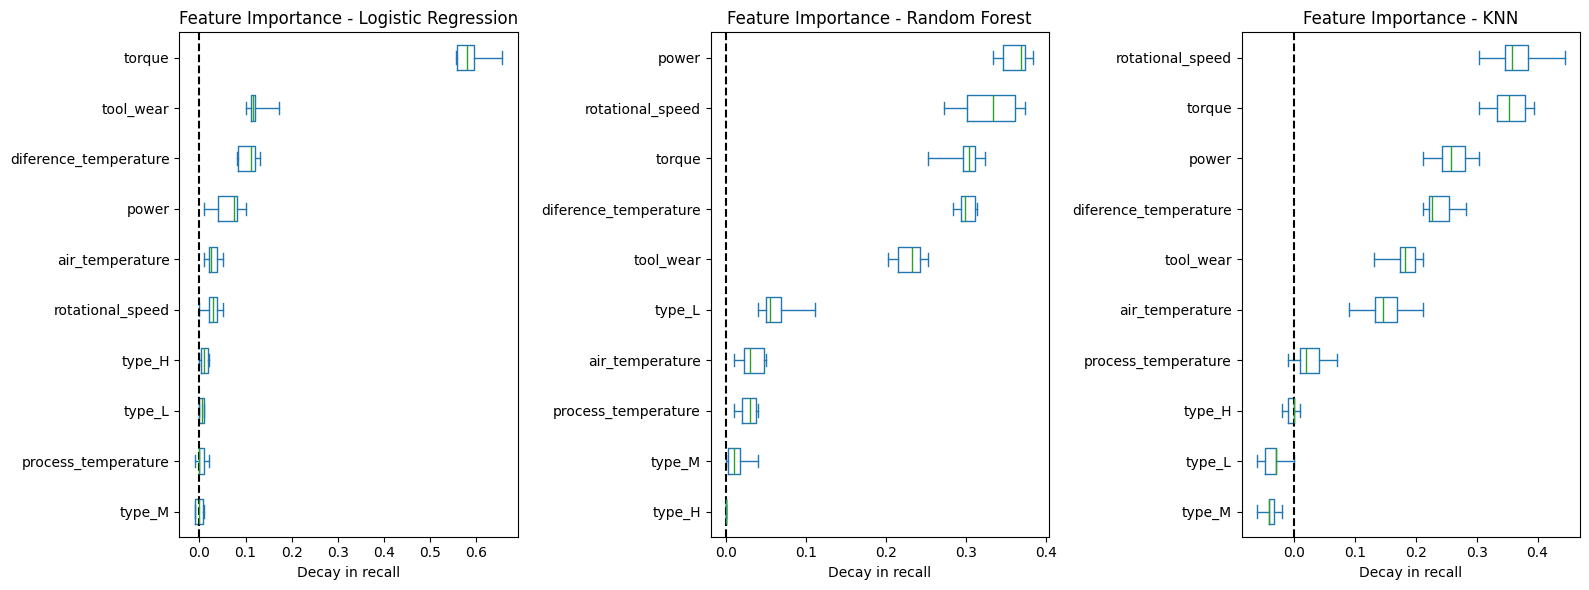

In [56]:
plot_feature_importance(y_test_all, X_test_all, model_report_all_smote, "recall", 1, 3)

### Observations:
- Logistic regression shows the same behavior
- The new feature `power` is the most important one on the random forest model, with `rotational_speed` now in second place and `torque` and `diference_temperature` tied for third and fourth place
- KNN had a tie between `rotational_speed` and `torque` for first place, with the new features in third and fourth place

# Summary
### Based on the analysis of every model trained and tested using two methods to balance the data, it is clear that the logistic regression model is not the right choice. Despite having a constant behavior on all tests, the number of false positives was always too high, which is very bad for a production line environment.
### The KNN model only had good performances when `SMOTE` was applied, but suffered from the same issue as the logistic regression.
### The best model was the random forest with the new features, which had a consistent low number of false negatives and by far the lowest number of false positives. Another point is the high scores on the `ROC` curve, staying above 0.9 in every test, proving that this model is excellent at discriminating the data between both classes.
### As mentioned in the model analysis, it would be interesting to test the random forest model trained with the `class_weight` parameter, the new features and a `threshold` of 0.6 to check if its performance is better than the results displayed without changing the `threshold`

# Random Forest with different `threshold`

In [104]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

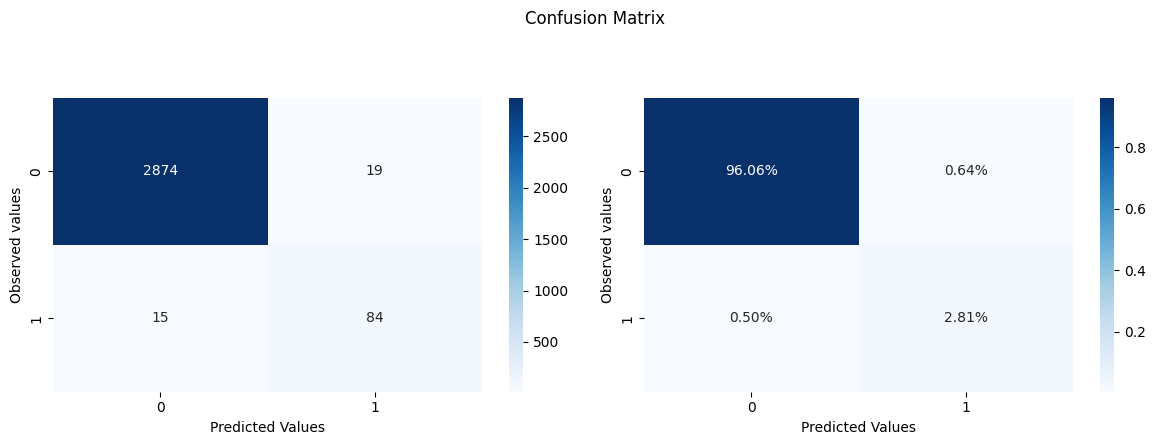

In [108]:
y_pred_probabilities = model_report_all["Random Forest"]["model"].predict_proba(X_test_all)[:,1]
# Changing the threshold to 0.6
y_pred_adjusted = (y_pred_probabilities >= 0.6).astype(int)
matrix = confusion_matrix(y_test_all, y_pred_adjusted)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('Confusion Matrix', y=1.1)
# Plot the first heatmap
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_xlabel("Predicted Values")
ax1.set_ylabel("Observed values")
# Plot the second heatmap
sns.heatmap(matrix / np.sum(matrix), annot=True, fmt=".2%", cmap="Blues", ax=ax2)
ax2.set_xlabel("Predicted Values")
ax2.set_ylabel("Observed values")
fig.tight_layout()
plt.show()

### Observations:
- Changing the threshold to 0.6, the model had a slight increase in false negatives, from 11 to 15, but a great decrease in false positives, from 35 to 19

# Conclusions
### Analyzing the random forest with the changed threshold, two scenarios come to mind in relation to the business:
- If the business wants a model that delevers the absolute lowest number of false negatives with a relatively low number of false positives, saying that this is the best approach for the company from a financial point of view, the random forest with all features and `SMOTE` will be selected as the best model because it has only 11 false negatives, which is the third lowest number, but only 35 false positives. In comparison, the model with the lowest number of false negatives is the first random forest, with 207 false positives, and the model with the second lowest number of false negatives is the random forest with all features, with 97 false positives
- If the business wants the lowest possible number of false negatives but don't want to keep stoping their machines a lot of times because of false positives, saying that this is the best approach from a financial point of view, then this last model of the random forest with the new features and the `class_weight` parameter will be used with a threshold of 0.6, having 15 false negatives, but only 19 false positives, giving the lowest total number of wrong predictions out of any model

## From this point forward, I'm assuming that the business prefers the second approach, so the model that will be put into production will be the random forest with the modified threshold